# The Pre-FOMC Drift and the Secular Decline in Long-Term Interest Rates

Examining Explained Returns of securities around FOMC meetings

Whitepaper [here](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4764451)

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter
from matplotlib.legend_handler import HandlerPatch

from FOMCDataPrep import DataPrep
from sklearn.decomposition import PCA

Access ```BBGEventCollect``` module

In [2]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\BBGEvent\root")
from BBGEventCollect import BBGCollect

First look at the return of Treasury Futures around FOMC announcement

In [3]:
def _get_bps(df: pd.DataFrame) -> pd.DataFrame: 
    
    return(df.sort_values(
        "date").
        assign(
            PX_diff = lambda x: x.PX_LAST.diff(),
            bps = lambda x: x.PX_diff / x.duration))

def get_tsy_bps() -> pd.DataFrame: 

    data_prep = DataPrep()

    df_tsy = data_prep.get_fut_data()
    df_deliv = data_prep.get_bond_deliverables()

    df_duration = (df_deliv.query(
        "variable == 'CONVENTIONAL_CTD_FORWARD_FRSK'").
        drop(columns = ["variable"]).
        rename(columns = {"value": "duration"}))


    df_out = (df_tsy.merge(
        right = df_duration, how = "inner", on = ["date", "security"]).
        groupby("security").
        apply(_get_bps))
    
    return df_out

df_tsy_bps = get_tsy_bps()

Searching for Futures Data
Found Data

Searching for Bond Future Deliverables
Found Data



In [4]:
def _get_order(df: pd.DataFrame, before: int) -> pd.DataFrame: 
    
    df_out = (df.sort_values(
        "date").
        reset_index(drop = True).
        reset_index().
        rename(columns = {"index": "day"}).
        assign(day = lambda x: x.day + before))
    
    return df_out

def get_order_bps(df_tsy_bps: pd.DataFrame, before: float = -3, after: float = 3) -> pd.DataFrame: 

    min_date = df_tsy_bps.date.min().date()

    df_dates = (BBGCollect()._get_days_window(
        ticker = "FDTR", before = before, after = after).
        query("start_date >= @min_date").
        reset_index(drop = True))

    df_combined = pd.DataFrame()
    for i, row in df_dates.iterrows():

        event_date, start_date, end_date = row

        df_tmp = (df_tsy_bps.query(
            "@start_date <= date <= @end_date").
            groupby("security").
            apply(_get_order, before).
            assign(event = i + 1).
            reset_index(drop = True))

        df_combined = pd.concat([df_combined, df_tmp])
        
    return df_combined

df_bps_event = get_order_bps(df_tsy_bps)

In [5]:
def get_cum_bps(df_bps_event: pd.DataFrame) -> pd.DataFrame: 
    
    df_cum_bps = (df_bps_event[
        ["day", "security", "bps"]].
        groupby(["day", "security"]).
        agg("mean").
        reset_index().
        assign(security = lambda x: x.security.str.split(" ").str[0].str.replace("1", "")).
        query("day != 4").
        pivot(index = "day", columns = "security", values = "bps").
        cumsum())
    
    return df_cum_bps

df_cum_bps = get_cum_bps(df_bps_event)

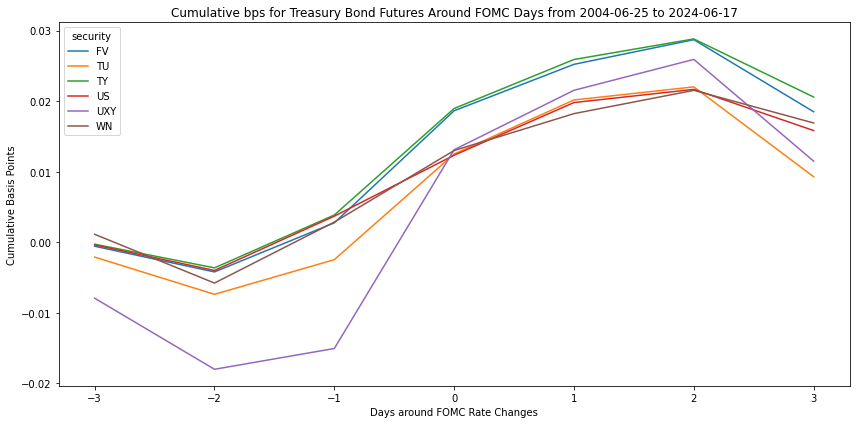

In [6]:
def plot_cumulative_bps(df_cum_bps: pd.DataFrame) -> plt.Figure:
    
    (df_cum_bps.plot(
        figsize = (12,6),
        ylabel = "Cumulative Basis Points",
        xlabel = "Days around FOMC Rate Changes",
        title = "Cumulative bps for Treasury Bond Futures Around FOMC Days from {} to {}".format(
            df_bps_event.date.min().date(),
            df_bps_event.date.max().date())))

    plt.tight_layout()
    
plot_cumulative_bps(df_cum_bps)